<center><h1>DSCI 552 Final Project</h1></center>
<br>
<center><font size="4">Sentiment Analysis of Reviews</font></center>
<br />
<table align="center">
    <tbody>
    <tr><td>Name</td><td>Parth Patel</td></tr>
    <tr><td>USC ID</td><td>5228107917</td></tr>
     <tr><td>Github Username</td><td>parthpar-usc</td></tr>
    <tr><td>Email</td><td>parthpar@usc.edu</td></tr>
    </tbody>
</table>


In [1]:
! pip install Tensorflow

Defaulting to user installation because normal site-packages is not writeable


## Import Required libraries

In [2]:
import os
import string
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

os.environ["TF_USE_LEGACY_KERAS"] = '1'

## 1(b) Data Exploration and Pre-processing

In [3]:
def load_data(folder):
    texts = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts
    

In [4]:
from collections import Counter
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '', text)     
    text = re.sub(r'[\t\n\r]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [5]:
def split_data(base_folder):
    texts, labels, categories = [], [], []
    train_texts, train_labels, train_categories = [], [], []
    test_texts, test_labels, test_categories = [], [], []

    if not os.path.isdir(base_folder):
        print(f"The directory {base_folder} was not found.")
        return None, None

    print(f"Loading data from {base_folder}...")
    for category in ['pos', 'neg']:
        category_folder = os.path.join(base_folder, category)
        if not os.path.isdir(category_folder):
            print(f"The directory {category_folder} does not exist.")
            continue

        for filename in os.listdir(category_folder):
            cv_number = int(filename.split('_')[0][2:])  
            filepath = os.path.join(category_folder, filename)
            split = 'train' if 0 <= cv_number < 700 else 'test'
            try:
                with open(filepath, 'r', encoding='utf-8') as file:
                    content = file.read()
                    cleaned_content = clean_text(content)
                    texts.append(cleaned_content)
                    labels.append(1 if category == 'pos' else 0)
                    categories.append(category)
                    if split == 'train':
                        train_texts.append(cleaned_content)
                        train_labels.append(1 if category == 'pos' else 0)
                        train_categories.append(category)
                    else:
                        test_texts.append(cleaned_content)
                        test_labels.append(1 if category == 'pos' else 0)
                        test_categories.append(category)
            except Exception as e:
                print(f"Error reading file {filename}: {e}")

    train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
    test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})
    return train_df, test_df

In [6]:
base_folder = '../Data'  
train_df, test_df = split_data(base_folder)

print("Training Data:")
print(train_df.tail())
print("\nTesting Data:")
print(test_df.tail())


Loading data from ../Data...
Training Data:
                                                   text  label
1395  synopsis when a meteorite crashlands in the ar...      0
1396  its now the anniversary of the slayings of jul...      0
1397  coinciding with the emerging popularity of mov...      0
1398  and now the highflying hong kong style of film...      0
1399  battlefield long boring and just plain stupid ...      0

Testing Data:
                                                  text  label
595  martial arts master steven seagal not to menti...      0
596  tarzan and the lost city is one of the most an...      0
597  vegas vacation is the fourth film starring che...      0
598  seen december at p m at the glenwood movieplex...      0
599  its difficult to expect much from a director w...      0


In [7]:
train_df

,text,label
0,plot derek zoolander is a male model he is als...,1
1,good will hunting is two movies in one an inde...,1
2,the story of us a rob reiner film is the secon...,1
3,the fighting sullivans contains a major plot d...,1
4,george little jonathan lipnicki wants a little...,1
...,...,...
1395,synopsis when a meteorite crashlands in the ar...,0
1396,its now the anniversary of the slayings of jul...,0
1397,coinciding with the emerging popularity of mov...,0
1398,and now the highflying hong kong style of film...,0


In [8]:
test_df

,text,label
0,assume nothing the phrase is perhaps one of th...,1
1,i actually am a fan of the original or so live...,1
2,a movie thats been as highly built up as the t...,1
3,anastasia contains something that has been lac...,1
4,before you read my review you gotta know that ...,1
...,...,...
595,martial arts master steven seagal not to menti...,0
596,tarzan and the lost city is one of the most an...,0
597,vegas vacation is the fourth film starring che...,0
598,seen december at p m at the glenwood movieplex...,0


In [9]:
data = pd.concat([train_df, test_df], ignore_index=True)
data

,text,label
0,plot derek zoolander is a male model he is als...,1
1,good will hunting is two movies in one an inde...,1
2,the story of us a rob reiner film is the secon...,1
3,the fighting sullivans contains a major plot d...,1
4,george little jonathan lipnicki wants a little...,1
...,...,...
1995,martial arts master steven seagal not to menti...,0
1996,tarzan and the lost city is one of the most an...,0
1997,vegas vacation is the fourth film starring che...,0
1998,seen december at p m at the glenwood movieplex...,0


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def count_unique_words(data):
    word_count = Counter()
    for text in data['text']:
        word_count.update(text.split())
    return len(word_count),word_count

In [11]:
unique_words,all_words=count_unique_words(data)
print(f"The number of unique words in the whole dataset (train + test) = {unique_words}")

The number of unique words in the whole dataset (train + test) = 47037


### The number of unique words in the whole dataset (train + test) = 47037


## Unique words List

In [12]:
all_words.keys()


dict_keys(['plot', 'derek', 'zoolander', 'is', 'a', 'male', 'model', 'he', 'also', 'very', 'dumb', 'and', 'impressionable', 'for', 'that', 'reason', 'secretly', 'hired', 'trained', 'so', 'secret', 'even', 'doesnt', 'know', 'about', 'it', 'by', 'an', 'underground', 'fashion', 'syndicate', 'to', 'assassinate', 'the', 'prime', 'minister', 'of', 'malaysia', 'who', 'wants', 'abolish', 'child', 'labor', 'in', 'his', 'country', 'will', 'fulfill', 'dirty', 'deed', 'ever', 'grace', 'world', 'new', 'look', 'this', 'funny', 'movie', 'find', 'out', 'below', 'critique', 'theres', 'place', 'our', 'stupid', 'comedies', 'films', 'which', 'dont', 'pretend', 'take', 'themselves', 'seriously', 'are', 'based', 'on', 'idiotic', 'premises', 'filled', 'with', 'jokes', 'time', 'them', 'many', 'would', 'argue', 'difficult', 'period', 'history', 'might', 'be', 'ideal', 'circumstance', 'during', 'relax', 'watching', 'something', 'completely', 'frivolous', 'well', 'if', 'youre', 'mood', 'some', 'mindless', 'enter

In [13]:
def review_length_stats(data):
    review_lengths = data['text'].str.split().apply(len)
    average_length = review_lengths.mean()
    std_dev_length = review_lengths.std()
    return average_length, std_dev_length,review_lengths

In [14]:
data['text'].str.split()

0       [plot, derek, zoolander, is, a, male, model, h...
1       [good, will, hunting, is, two, movies, in, one...
2       [the, story, of, us, a, rob, reiner, film, is,...
3       [the, fighting, sullivans, contains, a, major,...
4       [george, little, jonathan, lipnicki, wants, a,...
                              ...                        
1995    [martial, arts, master, steven, seagal, not, t...
1996    [tarzan, and, the, lost, city, is, one, of, th...
1997    [vegas, vacation, is, the, fourth, film, starr...
1998    [seen, december, at, p, m, at, the, glenwood, ...
1999    [its, difficult, to, expect, much, from, a, di...
Name: text, Length: 2000, dtype: object

In [15]:
avg_len,std_dev_len,review_lengths=review_length_stats(data)
avg_len=int(avg_len)
print(f"Average length of review = {avg_len}")

Average length of review = 644


### Average length of review = 644


In [16]:
std_dev_len=int(std_dev_len)
print(f"Standard deviation length = {std_dev_len}")

Standard deviation length = 285


### Average length of review = 285


In [17]:
review_lengths

0        616
1        278
2        839
3        256
4        960
        ... 
1995    1098
1996     971
1997     392
1998     698
1999     480
Name: text, Length: 2000, dtype: int64

### The histogram of review lengths

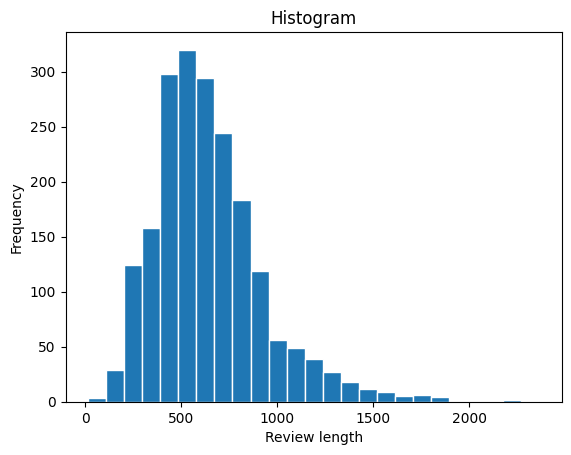

In [18]:
import matplotlib.pyplot as plt
plt.hist(review_lengths, bins=25, edgecolor='white') 
plt.xlabel('Review length')
plt.ylabel('Frequency')
plt.title('Histogram')
# plt.grid(True)
plt.show()

In [19]:
def tokenize_by_count(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df["text"])
    train_matrix = tokenizer.texts_to_matrix(train_df["text"], mode='count')
    test_matrix = tokenizer.texts_to_matrix(test_df["text"], mode='count')
    return train_matrix,test_matrix

In [20]:
train_matrix,test_matrix=tokenize_by_count(data)
train_matrix

array([[ 0., 28., 14., ...,  0.,  0.,  0.],
       [ 0., 18.,  9., ...,  0.,  0.,  0.],
       [ 0., 63., 26., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  9.,  3., ...,  0.,  0.,  0.],
       [ 0., 38.,  9., ...,  0.,  0.,  0.],
       [ 0., 53., 15., ...,  1.,  1.,  1.]])

In [21]:
test_matrix

array([[ 0., 40., 19., ...,  0.,  0.,  0.],
       [ 0., 98., 43., ...,  0.,  0.,  0.],
       [ 0., 33., 12., ...,  0.,  0.,  0.],
       ...,
       [ 0., 28.,  9., ...,  0.,  0.,  0.],
       [ 0., 44., 19., ...,  0.,  0.,  0.],
       [ 0., 22., 22., ...,  0.,  0.,  0.]])

In [22]:
def determine_length_threshold(data, percentile=0.70):
    review_lengths = data['text'].str.split().apply(len)
    return int(review_lengths.quantile(percentile))

threshold_len=determine_length_threshold(data)
threshold_len=int(threshold_len)
print(f"70% of review Length = {threshold_len}")

70% of review Length = 737


### 70% of review Length = 737


In [23]:
data

,text,label
0,plot derek zoolander is a male model he is als...,1
1,good will hunting is two movies in one an inde...,1
2,the story of us a rob reiner film is the secon...,1
3,the fighting sullivans contains a major plot d...,1
4,george little jonathan lipnicki wants a little...,1
...,...,...
1995,martial arts master steven seagal not to menti...,0
1996,tarzan and the lost city is one of the most an...,0
1997,vegas vacation is the fourth film starring che...,0
1998,seen december at p m at the glenwood movieplex...,0


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

def pad_truncate_sequences(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            # Truncate the sequence if longer than maxlen
            padded_sequences.append(seq[:maxlen])
        else:
            # Pad the sequence if shorter than maxlen
            padded_sequences.append(seq + [0] * (maxlen - len(seq)))
    return np.array(padded_sequences)

train_padded_sequences = pad_truncate_sequences(train_sequences, threshold_len)
test_padded_sequences = pad_truncate_sequences(test_sequences, threshold_len)

In [25]:
train_padded_sequences.shape


(1400, 737)

In [26]:
test_padded_sequences.shape

(600, 737)

## 1(C) Word Embeddings

In [27]:
def create_embedding_model(max_words, max_len, embedding_dim=32):
    input_layer = Input(shape=(max_len,))
    embedding = Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,))(input_layer)
    flatten = Flatten()(embedding)
    model = Model(inputs=input_layer, outputs=flatten)    
    model.summary()
    return model

model = create_embedding_model(max_words=5000, max_len=threshold_len)

/Users/parthpatel/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 737)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23584)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

## 1(D)Multi-Layer Perceptron

In [28]:
train_padded_sequences.shape

(1400, 737)

In [29]:
y = model.predict(train_padded_sequences)
y.shape

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


(1400, 23584)

In [30]:
model.input

<KerasTensor shape=(None, 737), dtype=float32, sparse=None, name=keras_tensor>

In [31]:
train_embedding_outputs = model.predict(train_padded_sequences)
test_embedding_outputs = model.predict(test_padded_sequences)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


In [32]:
train_embedding_outputs.shape

(1400, 23584)

In [33]:
def create_mlp_model(input_shape):
    model = Sequential([
        Dense(50, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [34]:
mlp_model = create_mlp_model(train_embedding_outputs.shape[1])
mlp_model.summary()
history = mlp_model.fit(train_embedding_outputs, train_df['label'], epochs=2, batch_size=10, verbose=1)

/Users/parthpatel/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │     1,179,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,184,401 (4.52 MB)

 Trainable params: 1,184,401 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4924 - loss: 0.7036
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5550 - loss: 0.6816


In [35]:
train_loss, train_accuracy = mlp_model.evaluate(train_embedding_outputs, train_df["label"], verbose=0)
print(f"Train Accuracy of MLP Model: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = mlp_model.evaluate(test_embedding_outputs, test_df["label"], verbose=0)
print(f"Test Accuracy of MLP Model: {test_accuracy * 100:.2f}%")

Train Accuracy of MLP Model: 71.36%
Test Accuracy of MLP Model: 55.17%


## 1(E)One-Dimensional Convolutional Neural Network

In [36]:
def embedding_cnn_model(max_words, max_len, embedding_dim=32):
    # Define the input layer
    input_layer = Input(shape=(max_len,))
    
    # Define the embedding layer
    embedding = Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,))(input_layer)
    
    # Insert Conv1D after embedding layer
    conv1d = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(embedding)
    
    # Insert MaxPooling1D after Conv1D layer
    max_pooling = MaxPooling1D(pool_size=2, strides=2)(conv1d)
    
    # Flatten the output to feed into a dense layer
    flatten = Flatten()(max_pooling)
    
    # Optionally, add more layers or directly to outputs if needed for your specific use case
    
    # Create the model
    model = Model(inputs=input_layer, outputs=flatten)
    
    # Print the model summary
    model.summary()
    
    return model

In [37]:
cnn_model = embedding_cnn_model(max_words=5000, max_len=threshold_len)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 737)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 737, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 368, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11776)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,104 (637.12 KB)

 Trainable params: 163,104 (637.12 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
train_cnn_embedding_outputs = cnn_model.predict(train_padded_sequences)
test_cnn_embedding_outputs = cnn_model.predict(test_padded_sequences)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [39]:
train_cnn_embedding_outputs.shape

(1400, 11776)

In [41]:
mlp_model_2 = create_mlp_model(train_cnn_embedding_outputs.shape[1])
mlp_model_2.summary()
history_2 = mlp_model_2.fit(train_cnn_embedding_outputs, train_df['label'], epochs=2, batch_size=10, verbose=1)
train_loss, train_accuracy = mlp_model_2.evaluate(train_cnn_embedding_outputs, train_df["label"], verbose=0)
print(f"Train Accuracy of 1-D CNN Model: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = mlp_model_2.evaluate(test_cnn_embedding_outputs, test_df["label"], verbose=0)
print(f"Test Accuracy of 1-D CNN Model: {test_accuracy * 100:.2f}%")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 50)             │       588,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,001 (2.27 MB)

 Trainable params: 594,001 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5089 - loss: 0.7131
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5340 - loss: 0.6872
Train Accuracy of 1-D CNN Model: 50.00%
Test Accuracy of 1-D CNN Model: 50.00%


In [42]:


# Assuming data is a pandas DataFrame
# tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
word_index = tokenizer.word_index
data_last = pad_sequences(sequences)


encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data['label'])

X_train, X_test, y_train, y_test = train_padded_sequences,test_padded_sequences,train_df['label'],test_df['label']


last_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=32, input_shape=(data_last.shape[1],)),
    LSTM(128, return_sequences=False, dropout=0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

last_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = last_model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

train_accuracy = last_model.evaluate(X_train, y_train)[1]
test_accuracy = last_model.evaluate(X_test, y_test)[1]

print(f"Train Accuracy of LSTM RNN Model: {train_accuracy}")
print(f"Test Accuracy of LSTM RNN Model: {test_accuracy}")


Epoch 1/50


/Users/parthpatel/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - accuracy: 0.5151 - loss: 0.6919 - val_accuracy: 0.5550 - val_loss: 0.6881
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.5691 - loss: 0.6776 - val_accuracy: 0.5633 - val_loss: 0.6890
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6442 - loss: 0.6237 - val_accuracy: 0.5383 - val_loss: 0.7060
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6689 - loss: 0.5496 - val_accuracy: 0.5483 - val_loss: 0.8113
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6523 - loss: 0.5031 - val_accuracy: 0.5367 - val_loss: 0.9718
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6305 - loss: 0.5121 - val_accuracy: 0.5467 - val_loss: 1.1119
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6806 - loss: 0.4850 - val_accuracy: 0.5483 - val_loss: 1.2506
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6495 - loss: 0.4846 - val